# Genarate data BW $F$ vector and fit with Breit-Wigner for 2 poles and 1 channel
## Do not mind tho Sub-Intensity plots 


In [1]:
from __future__ import annotations

import graphviz
import numpy as np
import qrules
import sympy as sp
from ampform.io import aslatex
from IPython.display import Latex
from qrules.particle import Particle, ParticleCollection

# Collect dynamics symbols

| Resonance | $m$ [MeV] | $\Gamma$ [MeV] | $J^P$ |
|-----------|-----------|----------------|-------|
| $N^*(1440)$ | 1398      | 167            | $\frac{1}{2}^{+}$ |
| $N^*(1535)$ | 1530      | 210            | $\frac{1}{2}^{-}$ |
| $N^*(1650)$ | 1668      | 194            | $\frac{1}{2}^{-}$ |
| $N^*(1710)$ | 1749      | 263            | $\frac{1}{2}^{+}$ |
| $N^*(1880)$ | 1876      | 261            | $\frac{1}{2}^{+}$ |
| $N^*(1895)$ | 2045      | 240            | $\frac{1}{2}^{-}$ |
| $N^*(1900)$ | 1970      | 255            | $\frac{3}{2}^{+}$ |

In [2]:
def load_particle_database() -> ParticleCollection:
    particle_database = qrules.load_default_particles()
    additional_definitions = qrules.io.load(
        "../../../additional-nstar-sigma-definitions.yml"
    )
    particle_database.update(additional_definitions)
    return particle_database


PARTICLE_DB = load_particle_database()

Propagating quantum numbers:   0%|          | 0/36 [00:00<?, ?it/s]

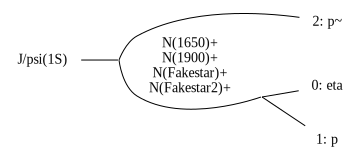

In [3]:
reaction = qrules.generate_transitions(
    initial_state="J/psi(1S)",
    final_state=["eta", "p", "p~"],
    allowed_intermediate_particles=["N(Fakestar2)+","N(1650)+","N(1900)+","N(Fakestar)+"],
    allowed_interaction_types=["strong"],
    formalism="helicity",
    # mass_conservation_factor=5.0,
    particle_db=PARTICLE_DB,
)
dot = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(dot)

In [4]:
from kmatrix import COLLECTED_X_SYMBOLS, create_dynamics_symbol

In [5]:
import ampform

model_builder = ampform.get_builder(reaction)
model_builder.adapter.permutate_registered_topologies()
model_builder.scalar_initial_state_mass = True
model_builder.stable_final_state_ids = [0, 1, 2]
for name in reaction.get_intermediate_particles().names:
    model_builder.set_dynamics(name, create_dynamics_symbol)
model = model_builder.formulate()

In [6]:
selected_amplitudes = {
    k: v for i, (k, v) in enumerate(model.amplitudes.items()) if i < 3
}
src = aslatex(selected_amplitudes)

## Formulate dynamics expression

In [7]:
for symbol, resonances in COLLECTED_X_SYMBOLS.items():
    display(symbol)
    for p, _ in resonances:
        print(f"  {p.name:<20s} {p.mass:>8g} GeV  {p.width:>8g} GeV ")
model.parameter_defaults

X_{Q=+1, S=1/2, P =-1}

  N(Fakestar2)+            1.75 GeV       0.6 GeV 
  N(1650)+                 1.65 GeV     0.125 GeV 


X_{Q=+1, S=3/2, P =1}

  N(Fakestar)+             1.82 GeV       0.6 GeV 
  N(1900)+                 1.92 GeV       0.2 GeV 


ParameterValues({
  C_{J/\psi(1S) \to N(1650)^{+}_{+1/2} \overline{p}_{+1/2}; N(1650)^{+} \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1650)^{+}_{+1/2} \overline{p}_{-1/2}; N(1650)^{+} \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar2)^+_{+1/2} \overline{p}_{+1/2}; N(Fakestar2)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar2)^+_{+1/2} \overline{p}_{-1/2}; N(Fakestar2)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+3/2} \overline{p}_{+1/2}; N(Fakestar)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+1/2} \overline{p}_{+1/2}; N(Fakestar)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+1/2} \overline{p}_{-1/2}; N(Fakestar)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1900)^+_{+3/2} \overline{p}_{+1/2}; N(1900)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1900)^+_{+1/2} \overline{p}_{+1/2}; N(1900)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1900)^+_

## Formulate Dynamics

### Phasespace factor

In [8]:
from ampform.kinematics.phasespace import Kallen
from ampform.sympy import unevaluated
from sympy import Abs


@unevaluated(real=False)
class PhaseSpaceCM(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\rho^\mathrm{{CM}}_{{{m1},{m2}}}\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return -16 * sp.pi * sp.I * ChewMandelstam(s, m1, m2)


@unevaluated(real=False)
class ChewMandelstam(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\Sigma\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        q = BreakupMomentum(s, m1, m2)
        return (
            1
            / (16 * sp.pi**2)
            * (
                (2 * q / sp.sqrt(s))
                * sp.log(Abs((m1**2 + m2**2 - s + 2 * sp.sqrt(s) * q) / (2 * m1 * m2)))
                - (m1**2 - m2**2) * (1 / s - 1 / (m1 + m2) ** 2) * sp.log(m1 / m2)
            )
        )


@unevaluated(real=False)
class BreakupMomentum(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"q\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return sp.sqrt(Kallen(s, m1**2, m2**2)) / (2 * sp.sqrt(s))


@unevaluated(real=False)
class EnergyDecaywidth(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    gamma_R: Any
    _latex_repr_ = R"\Gamma_s\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2, gamma_R = self.args
        return gamma_R * PhaseSpaceCM(s, m1, m2)

### Relativistic Breit-Wigner

In [9]:
from ampform.dynamics.builder import TwoBodyKinematicVariableSet

PARAMETERS_BW = {}
PARAMETERS_BW.update(model.parameter_defaults)

def formulate_rel_bw(
    resonances: list[tuple[Particle, TwoBodyKinematicVariableSet]],
) -> sp.Expr:
    (p1, variables), *_ = resonances
    s = variables.incoming_state_mass**2
    m_a = variables.outgoing_state_mass1
    m_b = variables.outgoing_state_mass2
    q = BreakupMomentum(s, m_a, m_b)
    w = [sp.Symbol(Rf"w_{{{p.latex}}}") for p, _ in resonances]
    m = [sp.Symbol(Rf"m_{{{p.latex}}}") for p, _ in resonances]
    b = [sp.Symbol(Rf"b_{{{p.latex}}}") for p, _ in resonances]
    d = [sp.Symbol(Rf"d_{{{p.latex}}}") for p, _ in resonances]
    L = [sp.Symbol(Rf"L_{{{p.latex}}}") for p, _ in resonances]
    w_s = (EnergyDecaywidth(s, m_a, m_b, w_) for w_ in w)
    rel_bw = sum((w_ * m_) / (m_**2 - s - m_ * w_s_) for m_, w_, w_s_ in zip(m, w, w_s))
    for i, (p, va) in enumerate(resonances):
        PARAMETERS_BW[w[i]] = p.width
        PARAMETERS_BW[m[i]] = p.mass
        PARAMETERS_BW[b[i]] = 1
        PARAMETERS_BW[d[i]] = 1
        PARAMETERS_BW[L[i]] = 0
    return rel_bw

### $K$ matrix 

In [10]:
PARAMETERS_F = {}
PARAMETERS_F.update(model.parameter_defaults)

def formulate_K_matrix(
    resonances: list[tuple[Particle, TwoBodyKinematicVariableSet]],
) -> sp.Expr:
    (p1, variables), *_ = resonances
    s = variables.incoming_state_mass**2
    m_a = variables.outgoing_state_mass1
    m_b = variables.outgoing_state_mass2
    g= [sp.Symbol(Rf"g_{{{p.latex}}}") for p, _ in resonances]
    m = [sp.Symbol(Rf"m_{{{p.latex}}}") for p, _ in resonances]

    kmatrix = sum(
        (g_**2) / (m_**2 - s) for m_, g_ in zip(m, g)
    )
    for i, (p, va) in enumerate(resonances):
        PARAMETERS_F[m[i]] = p.mass
        PARAMETERS_F[g[i]] = 1
    return kmatrix

### $P$ vector

In [11]:


def formulate_P_vector(
    resonances: list[tuple[Particle, TwoBodyKinematicVariableSet]],
) -> sp.Expr:
    (p1, variables), *_ = resonances
    s = variables.incoming_state_mass**2
    m_a = variables.outgoing_state_mass1
    m_b = variables.outgoing_state_mass2
    g = [sp.Symbol(Rf"g_{{{p.latex}}}") for p, _ in resonances]
    m = [sp.Symbol(Rf"m_{{{p.latex}}}") for p, _ in resonances]
    beta = [sp.Symbol(Rf"\beta_{{{p.latex}}}") for p, _ in resonances]
    P_vector = sum(
        ( g_ * beta_ ) / (m_**2 - s)
        for m_,g_, beta_ in zip(m, g, beta)
    )
    for i, (p, va) in enumerate(resonances):
        PARAMETERS_F[m[i]] = p.mass
        PARAMETERS_F[beta[i]] = 1 + 0j
        PARAMETERS_F[g[i]] = 1
    return P_vector

### $F$ vector

In [12]:
def formulate_F_vector(
    resonances: list[tuple[Particle, TwoBodyKinematicVariableSet]],
) -> sp.Expr:
    (p1,variables), *_ = resonances
    s = variables.incoming_state_mass**2
    m_a = variables.outgoing_state_mass1
    m_b = variables.outgoing_state_mass2
    rho = PhaseSpaceCM(s, m_a, m_b)
    K = formulate_K_matrix(resonances)
    P = formulate_P_vector(resonances)
    Fvector = (1 / (1 - rho * K)) * P
    return Fvector

### Model relativistic Breit-Wigner

In [13]:
import attrs
from ampform.helicity import ParameterValues

dynamics_expressions_rel_bw = {
    symbol: formulate_rel_bw(resonances)
    for symbol, resonances in COLLECTED_X_SYMBOLS.items()
}
model_rel_bw = attrs.evolve(
    model,
    parameter_defaults=ParameterValues({
        **model.parameter_defaults,
        **PARAMETERS_BW,
    }),
)

In [14]:
full_expression_rel_bw = model_rel_bw.expression.doit().xreplace(
    dynamics_expressions_rel_bw
)

### Model $F$ vector

In [15]:
dynamics_expressions_fvector = {
    symbol: formulate_F_vector(resonances)
    for symbol, resonances in COLLECTED_X_SYMBOLS.items()
}
model_fvector = attrs.evolve(
    model,
    parameter_defaults=ParameterValues({
        **model.parameter_defaults,
        **PARAMETERS_F,
    }),
)
Latex(aslatex(dynamics_expressions_fvector))

<IPython.core.display.Latex object>

In [16]:
model_fvector.parameter_defaults

ParameterValues({
  C_{J/\psi(1S) \to N(1650)^{+}_{+1/2} \overline{p}_{+1/2}; N(1650)^{+} \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1650)^{+}_{+1/2} \overline{p}_{-1/2}; N(1650)^{+} \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar2)^+_{+1/2} \overline{p}_{+1/2}; N(Fakestar2)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar2)^+_{+1/2} \overline{p}_{-1/2}; N(Fakestar2)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+3/2} \overline{p}_{+1/2}; N(Fakestar)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+1/2} \overline{p}_{+1/2}; N(Fakestar)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+1/2} \overline{p}_{-1/2}; N(Fakestar)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1900)^+_{+3/2} \overline{p}_{+1/2}; N(1900)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1900)^+_{+1/2} \overline{p}_{+1/2}; N(1900)^+ \to \eta_{0} p_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(1900)^+_

In [17]:
full_expression_fvector = model_fvector.expression.doit().xreplace(
    dynamics_expressions_fvector
)
sp.count_ops(full_expression_fvector)

5591

### Create Parametrized Function


In [18]:
from tensorwaves.function.sympy import create_parametrized_function

unfolded_expression_rel_bw = full_expression_rel_bw.doit()

intensity_func_rel_bw = create_parametrized_function(
    expression=unfolded_expression_rel_bw,
    backend="jax",
    parameters=PARAMETERS_BW,
)

In [19]:
unfolded_expression_fvector = full_expression_fvector.doit()

intensity_func_fvector = create_parametrized_function(
    expression=unfolded_expression_fvector,
    backend="jax",
    parameters=PARAMETERS_F,
)

## Update parameters

In [20]:
new_parameters_fvector = {
    R"m_{N(Fakestar)^+}": 1.95,
    R"\beta_{N(Fakestar)^+}": 1 + 0j,
    R"m_{N(1900)^+}": 1.9,
    R"\beta_{N(1900)^+}": 1 + 0j,
    R"g_{N(1900)^+}": 1,
    R"g_{N(Fakestar)^+}": 1,
    R"m_{N(Fakestar2)^+}": 1.75,
    R"\beta_{N(Fakestar2)^+}": 1 + 0j,
    R"m_{N(1650)^{+}}": 1.65,
    R"\beta_{N(1650)^{+}}": 1 + 0j,
    R"g_{N(1650)^{+}}": 1.65,
    R"g_{N(Fakestar2)^+}": 1,
}

new_parameters_relbw = {
    R"m_{N(Fakestar)^+}": 1.85,
    R"w_{N(Fakestar)^+}": 1/1.85,
    R"m_{N(1900)^+}": 1.9,
    R"w_{N(1900)^+}": 1/1.9,
    R"m_{N(Fakestar2)^+}": 1.75,
    R"w_{N(Fakestar2)^+}": 1/1.75,
    R"m_{N(1650)^{+}}": 1.65,
    R"w_{N(1650)^{+}}": 1/1.65,
}

In [21]:
intensity_func_fvector.update_parameters(new_parameters_fvector)
intensity_func_rel_bw.update_parameters(new_parameters_relbw)
intensity_func_fvector.parameters

{'C_{J/\\psi(1S) \\to N(1650)^{+}_{+1/2} \\overline{p}_{+1/2}; N(1650)^{+} \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(1650)^{+}_{+1/2} \\overline{p}_{-1/2}; N(1650)^{+} \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar2)^+_{+1/2} \\overline{p}_{+1/2}; N(Fakestar2)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar2)^+_{+1/2} \\overline{p}_{-1/2}; N(Fakestar2)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+3/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{-1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(1900)^+_{+3/2} \\overline{p}_{+1/2}; N(1900)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(1900)^+_{+1/2} \\overline{p}_{+1/2}; N(1900)^+ \\to \\eta_{0} p_{+1/2}}': (1

##  Generate data with $F$ vector
### Generate phase space sample

In [22]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [23]:
from tensorwaves.data import SympyDataTransformer

helicity_transformer = SympyDataTransformer.from_sympy(
    model.kinematic_variables, backend="numpy"
)

In [24]:
import pandas as pd
from tensorwaves.data import (
    IntensityDistributionGenerator,
    SympyDataTransformer,
    TFPhaseSpaceGenerator,
    TFUniformRealNumberGenerator,
    TFWeightedPhaseSpaceGenerator,
)

rng = TFUniformRealNumberGenerator(seed=0)
phsp_generator = TFPhaseSpaceGenerator(
    initial_state_mass=reaction.initial_state[-1].mass,
    final_state_masses={i: p.mass for i, p in reaction.final_state.items()},
)
phsp_momenta = phsp_generator.generate(100_000, rng)
phsp = helicity_transformer(phsp_momenta)
phsp = {k: v.real for k, v in phsp.items()}
phsp

Generating phase space sample:   0%|          | 0/100000 [00:00<?, ?it/s]

I0000 00:00:1716372952.394881  324530 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
<lambdifygenerated-3>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(x0[:, 1:]**2, axis=1) + x0[:, 0]**2)], default=nan)
<lambdifygenerated-4>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(x0[:, 1:]**2, axis=1) + x0[:, 0]**2)], default=nan)
<lambdifygenerated-5>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(x0[:, 1:]**2, axis=1) + x0[:, 0]**2)], default=nan)


{'m_01': array([1.81857778, 1.80863875, 1.86758228, ..., 1.7217908 , 1.88162305,
        1.95955089]),
 'm_02': array([1.70745362, 1.77483717, 1.56984082, ..., 2.13907063, 1.99774363,
        2.0295025 ]),
 'm_12': array([2.33002756, 2.2870134 , 2.38733903, ..., 2.0276747 , 2.02981933,
        1.92170012]),
 'phi_0': array([ 1.97016286, -2.8765596 ,  0.75357421, ...,  0.19730572,
        -0.45861856,  1.57182959]),
 'phi_0^01': array([-1.97869891,  2.40627766, -2.02701505, ...,  1.42458459,
         0.78477173,  2.00132783]),
 'phi_0^02': array([ 0.98414884, -1.41787483,  1.80055274, ..., -2.62005351,
        -1.37701865, -1.58606652]),
 'phi_01': array([-0.00476082, -0.46629838, -0.49331781, ...,  2.95178512,
         2.14918814, -1.97763388]),
 'phi_1^12': array([-0.5234414 ,  0.53541189, -1.32700284, ...,  2.04917998,
         2.17445382,  1.30218432]),
 'phi_02': array([-1.98053067,  1.48563902,  3.08718583, ..., -1.7995076 ,
        -2.40408988, -0.99517043]),
 'theta_0': array([1

## Plot Sub-Intensities

In [25]:
import re

from tensorwaves.interface import ParametrizedFunction


def compute_sub_intensity(
    func: ParametrizedFunction,
    input_data: DataSample,
    resonances: list[str],
    coupling_pattern:str=r"(\\beta|g)",
):
    original_parameters = dict(func.parameters)
    negative_lookahead = f"(?!{'|'.join(map(re.escape, resonances))})"
    # https://regex101.com/r/WrgGyD/1
    pattern = rf"^{coupling_pattern}({negative_lookahead}.)*$"
    set_parameters_to_zero(func, pattern)
    array = func(input_data)
    func.update_parameters(original_parameters)
    return array


def set_parameters_to_zero(func: ParametrizedFunction, name_pattern: str) -> None:
    new_parameters = dict(func.parameters)
    for par_name in func.parameters:
        if re.match(name_pattern, par_name) is not None:
            new_parameters[par_name] = 0
    func.update_parameters(new_parameters)

In [26]:
total_intensities = intensity_func_fvector(phsp)
total_intensities_1 = intensity_func_rel_bw(phsp)
sub_intensities = {
    p: compute_sub_intensity(intensity_func_fvector, phsp, resonances=[p.latex], coupling_pattern= r"\\beta")
    for symbol, resonances in COLLECTED_X_SYMBOLS.items()
        for p, _ in resonances
}
sub_intensities_bw = {
    p: compute_sub_intensity(intensity_func_fvector, phsp, resonances=[p.latex])
    for symbol, resonances in COLLECTED_X_SYMBOLS.items()
        for p, _ in resonances
}

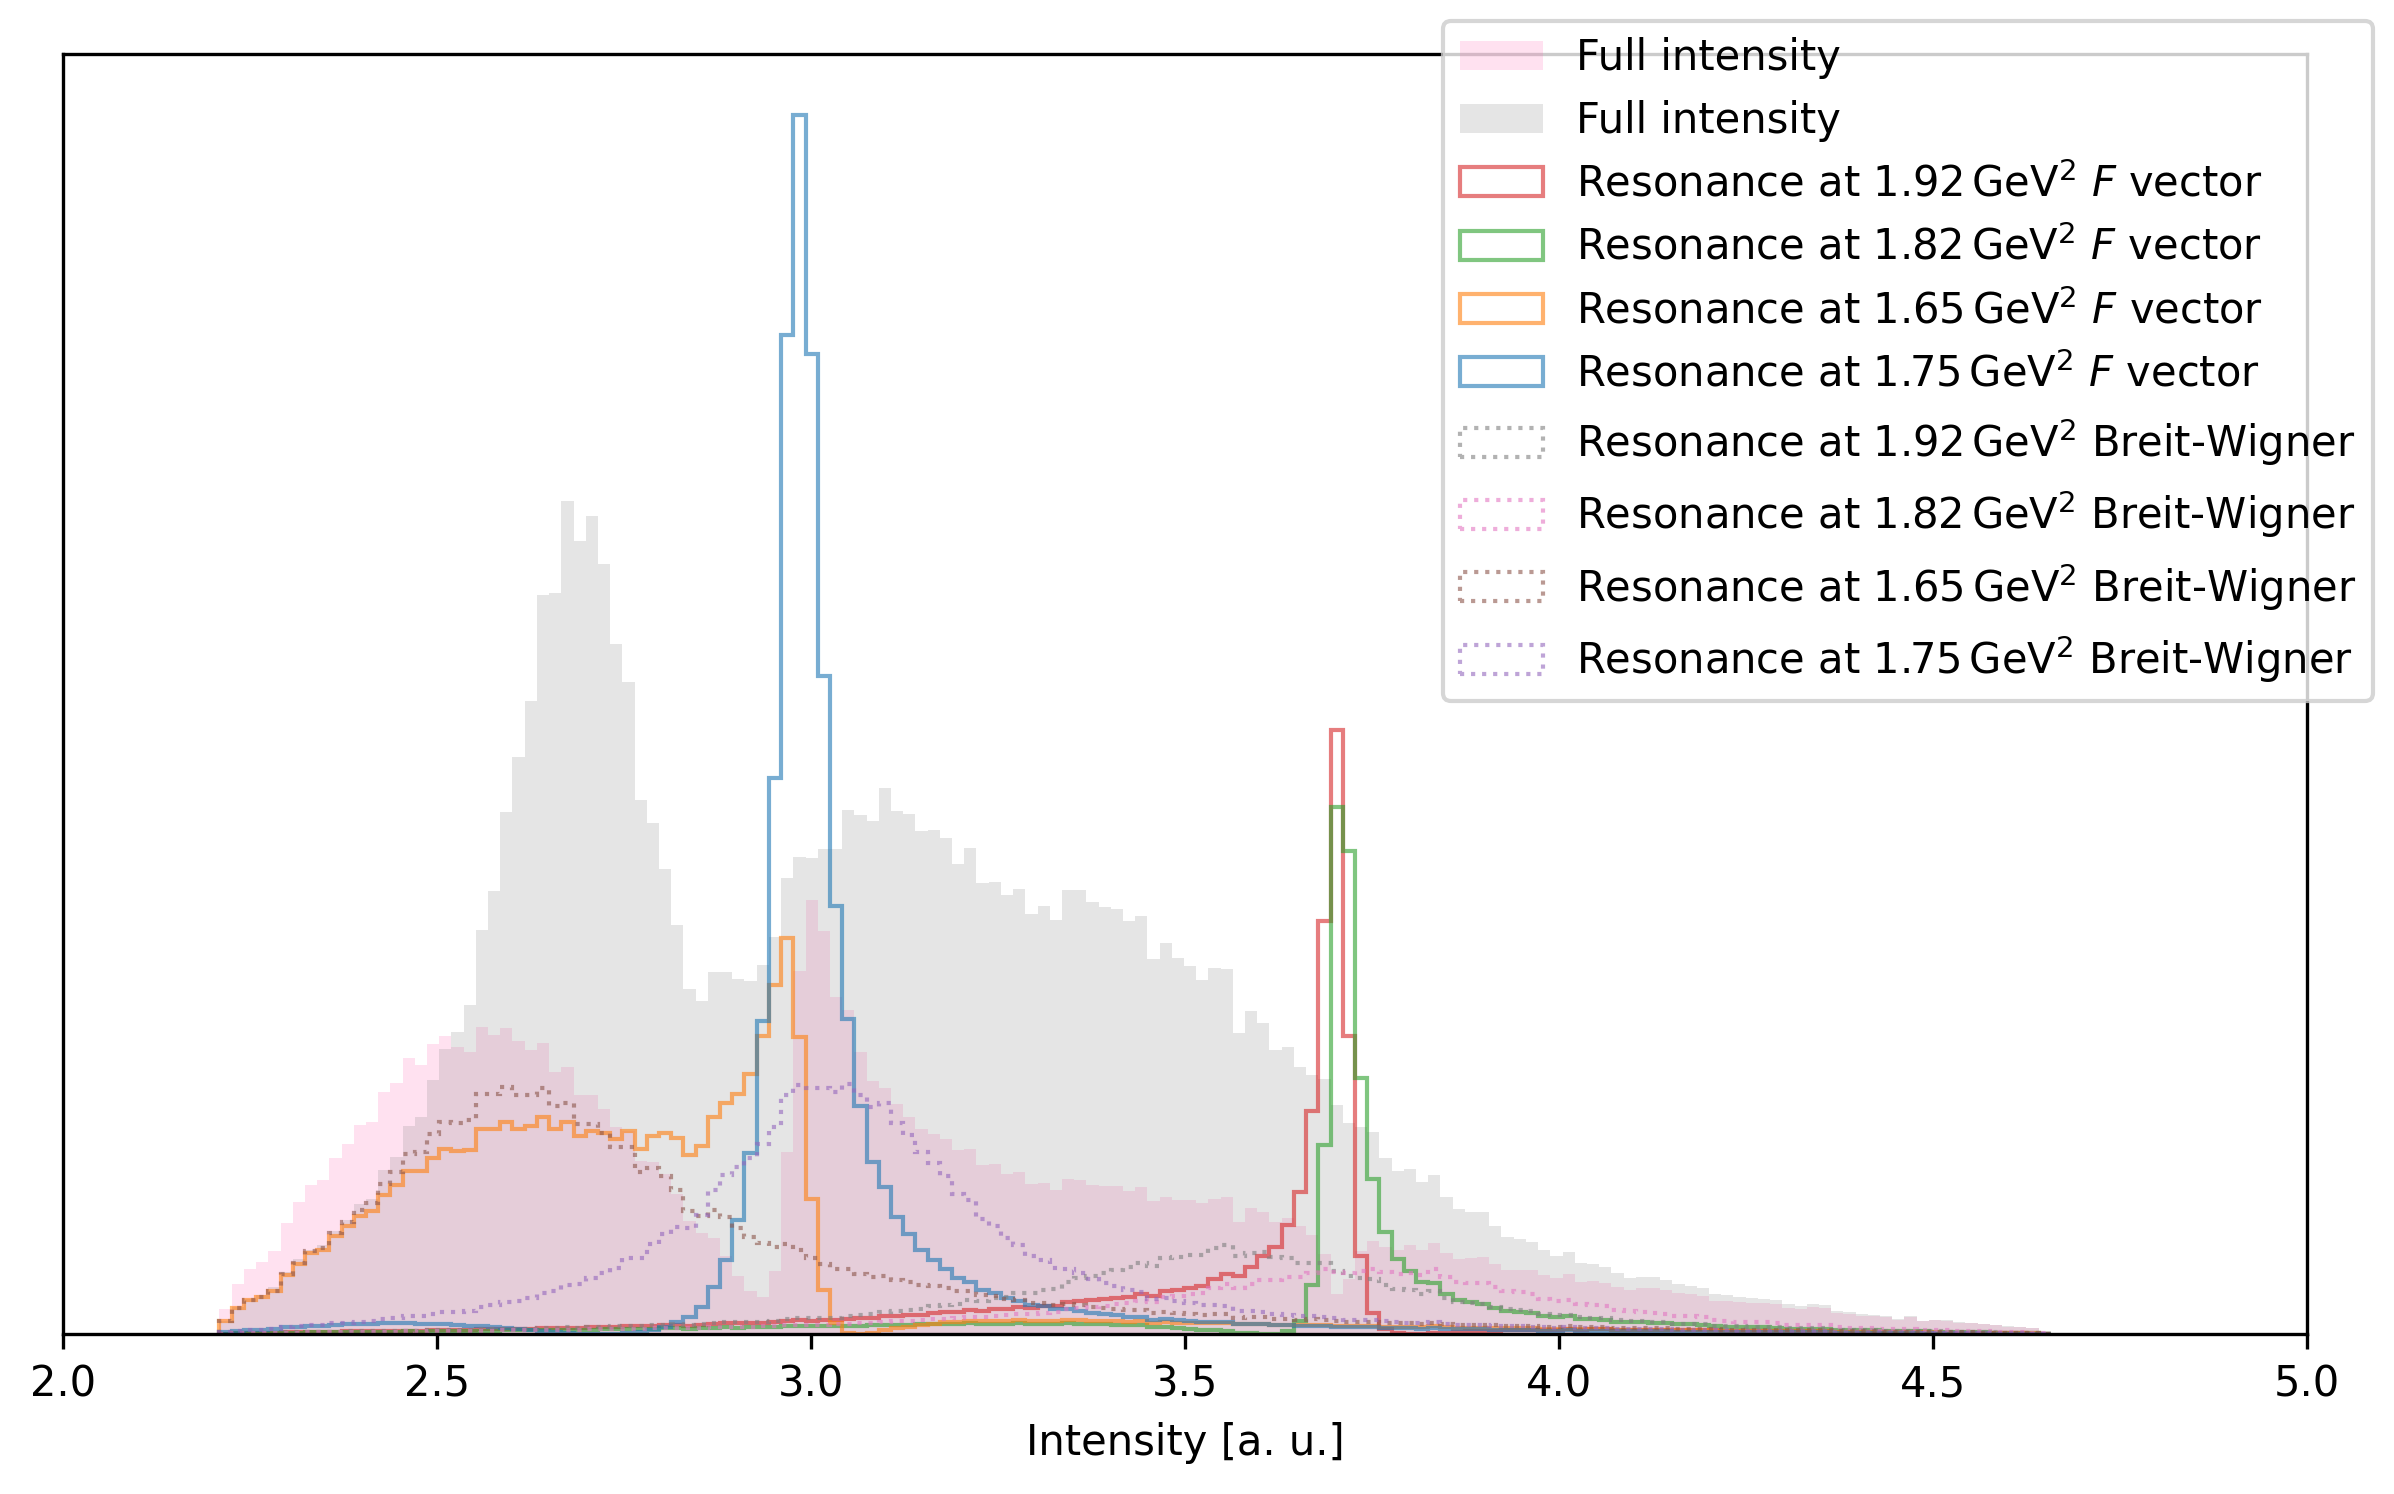

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.set_xlim(2, 5)
ax.set_xlabel(R"$m_{p\eta}^{2}$ [GeV^{2}]")
ax.set_xlabel(R"Intensity [a. u.]")
ax.set_yticks([])

bins = 150
phsp_projection = np.real(phsp["m_01"])**2
ax.hist(
    phsp_projection,
    weights=total_intensities,
    bins=bins,
    alpha=0.2,
    color="hotpink",
    label="Full intensity",
)
ax.hist(
    phsp_projection,
    weights=total_intensities_1,
    bins=bins,
    alpha=0.2,
    color="grey",
    label="Full intensity",
)
ax.hist(
    len(sub_intensities) * [phsp_projection],
    weights=list(sub_intensities.values()),
    bins=bins,
    alpha=0.6,
    label=[Rf"Resonance at ${p.mass}\,\mathrm{{GeV^2}}$ $F$ vector" for p in sub_intensities],
    histtype="step",
)

ax.hist(
    len(sub_intensities_bw) * [phsp_projection],
    weights=list(sub_intensities_bw.values()),
    bins=bins,
    alpha=0.6,
    label=[Rf"Resonance at ${p.mass}\,\mathrm{{GeV^2}}$ Breit-Wigner" for p in sub_intensities],
    histtype="step",
    ls="dotted",
)

fig.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Dynamics expressions

In [28]:
dynamics_expr_rel_bw, *_ = dynamics_expressions_rel_bw.values()
dynamics_expr_rel_bw

m_{N(1650)^{+}}*w_{N(1650)^{+}}/(-m_01**2 + m_{N(1650)^{+}}**2 - m_{N(1650)^{+}}*EnergyDecaywidth(m_01**2, m_0, m_1, w_{N(1650)^{+}})) + m_{N(Fakestar2)^+}*w_{N(Fakestar2)^+}/(-m_01**2 + m_{N(Fakestar2)^+}**2 - m_{N(Fakestar2)^+}*EnergyDecaywidth(m_01**2, m_0, m_1, w_{N(Fakestar2)^+}))

In [29]:
dynamics_expr_fvector, *_ = dynamics_expressions_fvector.values()
dynamics_expr_fvector

(\beta_{N(1650)^{+}}*g_{N(1650)^{+}}/(-m_01**2 + m_{N(1650)^{+}}**2) + \beta_{N(Fakestar2)^+}*g_{N(Fakestar2)^+}/(-m_01**2 + m_{N(Fakestar2)^+}**2))/(-(g_{N(1650)^{+}}**2/(-m_01**2 + m_{N(1650)^{+}}**2) + g_{N(Fakestar2)^+}**2/(-m_01**2 + m_{N(Fakestar2)^+}**2))*PhaseSpaceCM(m_01**2, m_0, m_1) + 1)

In [30]:
dynamics_func_bw = create_parametrized_function(
    expression=dynamics_expr_rel_bw.doit(),
    backend="numpy",
    parameters=model_rel_bw.parameter_defaults,
    use_cse=False,
)

In [31]:
dynamics_func_fvector = create_parametrized_function(
    expression=dynamics_expr_fvector.doit(),
    backend="numpy",
    parameters=model_fvector.parameter_defaults,
    use_cse=False,
)

### Weighted data with $F$ vector 

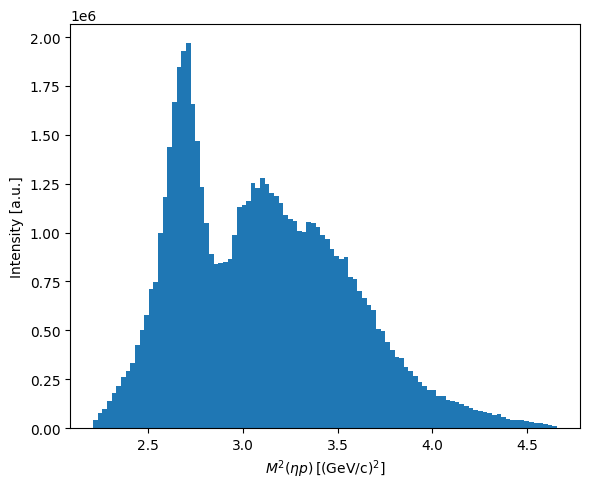

array([1.81857778, 1.80863875, 1.86758228, ..., 1.7217908 , 1.88162305,
       1.95955089])

In [32]:
import matplotlib.pyplot as plt

figD, axD = plt.subplots(figsize=(6, 5))
c = axD.hist(
    np.real(phsp["m_01"]) ** 2,
    bins=100,
    weights=np.real(intensity_func_rel_bw(phsp)),
)

axD.set_xlabel(R"$M^2\left(\eta p\right)\, \mathrm{[(GeV/c)^2]}$")
axD.set_ylabel(R"Intensity [a.u.]")
figD.tight_layout()
plt.show()
phsp["m_01"]

In [33]:
weighted_phsp_generator = TFWeightedPhaseSpaceGenerator(
    initial_state_mass=model.reaction_info.initial_state[-1].mass,
    final_state_masses={i: p.mass for i, p in model.reaction_info.final_state.items()},
)
data_generator = IntensityDistributionGenerator(
    domain_generator=weighted_phsp_generator,
    function=intensity_func_rel_bw,
    domain_transformer=helicity_transformer,
)
data_momenta = data_generator.generate(50_000, rng)
pd.DataFrame({
    (k, label): np.transpose(v)[i]
    for k, v in data_momenta.items()
    for i, label in enumerate(["E", "px", "py", "pz"])
})
phsp = helicity_transformer(phsp_momenta)
data = helicity_transformer(data_momenta)
data_frame = pd.DataFrame(data)
phsp_frame = pd.DataFrame(phsp)

Generating intensity-based sample:   0%|          | 0/50000 [00:00<?, ?it/s]

<lambdifygenerated-3>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(x0[:, 1:]**2, axis=1) + x0[:, 0]**2)], default=nan)
<lambdifygenerated-4>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(x0[:, 1:]**2, axis=1) + x0[:, 0]**2)], default=nan)
<lambdifygenerated-5>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(x0[:, 1:]**2, axis=1) + x0[:, 0]**2)], default=nan)
<lambdifygenerated-3>:3: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2, 0),True], [1j*sqrt(sum(x0[:, 1:]**2, axis=1) - x0[:, 0]**2),sqrt(-sum(

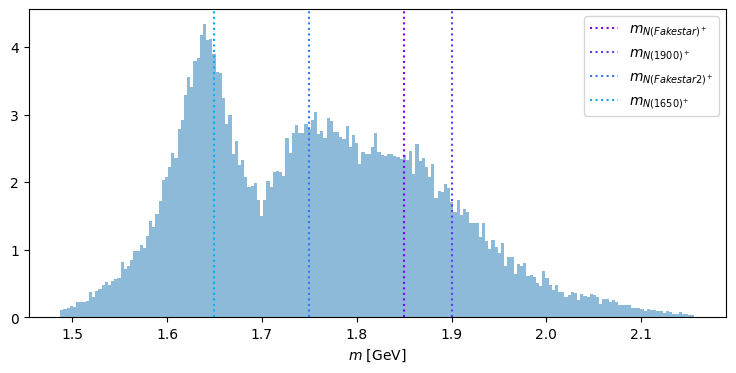

In [34]:
import matplotlib.pyplot as plt
from matplotlib import cm

resonances = sorted(
    model.reaction_info.get_intermediate_particles(),
    key=lambda p: p.mass,
)
evenly_spaced_interval = np.linspace(
    0, 1, len(intensity_func_fvector.parameters.items())
)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(
    np.real(data_frame["m_01"]),
    bins=200,
    alpha=0.5,
    density=True,
)
ax.set_xlabel("$m$ [GeV]")
for (k, v), color in zip(new_parameters_relbw.items(), colors):
    if k.startswith("m_{"):
        ax.axvline(
            x=v,
            linestyle="dotted",
            label=r"$" + k + "$",
            color=color,
        )
ax.legend()
plt.show()
# Multiply

### Perform fit

#### Define estimator

In [35]:
from tensorwaves.interface import DataSample


def safe_downcast_to_real(data: DataSample) -> DataSample:
    return {
        key: array.real if np.isrealobj(array) else array for key, array in data.items()
    }


data_real = safe_downcast_to_real(data)
phsp_real = safe_downcast_to_real(phsp)

In [36]:
from tensorwaves.estimator import UnbinnedNLL

estimator_bw = UnbinnedNLL(
    intensity_func_rel_bw,
    data=data_real,
    phsp=phsp_real,
    backend="jax",
)

estimator_fvector = UnbinnedNLL(
    intensity_func_fvector,
    data=data_real,
    phsp=phsp_real,
    backend="jax",
)

In [37]:


reaction_info = model.reaction_info
resonances = sorted(
    reaction_info.get_intermediate_particles(),
    key=lambda p: p.mass,
)
evenly_spaced_interval_F = np.linspace(
    0, 1, len(intensity_func_fvector.parameters.items())
)
colors_F = [cm.rainbow(x) for x in evenly_spaced_interval_F]
evenly_spaced_interval_BW = np.linspace(
    0, 1, len(intensity_func_rel_bw.parameters.items())
)
colors_BW = [cm.gist_rainbow(x) for x in evenly_spaced_interval_BW]


def indicate_masses(ax):
    ax.set_xlabel("$m$ [GeV]")
    for (k, v), color_F in zip(intensity_func_fvector.parameters.items(), colors_F):
        if k.startswith("m_{"):
            ax.axvline(
                x=v,
                linestyle="dotted",
                label=r"$" + k + "$" "(F vector)",
                color=color_F,
            )
    for (k, v), color_BW in zip(intensity_func_rel_bw.parameters.items(), colors_BW):
        if k.startswith("m_{"):
            ax.axvline(
                x=v,
                linestyle="dotted",
                label=r"$" + k + "$" "(Breit-Wigner)",
                color=color_BW,
            )


def compare_model(
    variable_name,
    data,
    phsp,
    function1,
    function2,
    bins=100,
):
    intensities1 = function1(phsp)
    intensities2 = function2(phsp)
    _, ax = plt.subplots(figsize=(9, 4))
    data_projection = np.real(data[variable_name])
    ax = plt.gca()
    ax.hist(
        data_projection,
        bins=bins,
        alpha=0.5,
        label="data",
        density=True,
    )
    phsp_projection = np.real(phsp[variable_name])
    ax.hist(
        phsp_projection,
        weights=np.array(intensities1),
        bins=bins,
        histtype="step",
        color="red",
        label="Fit model with K matrix",
        density=True,
    )
    ax.hist(
        phsp_projection,
        weights=np.array(intensities2),
        bins=bins,
        histtype="step",
        color="blue",
        label="Fit model with Breit Wigner",
        density=True,
    )
    indicate_masses(ax)
    ax.legend()

### Set initial parameters

In [38]:
m_1900=1.93
beta_1900= 0.9 + 0j
g_1900= 1.
m_1650= 1.65
beta_1650= 1 + 0j
g_1900= 1.
m_Fakestar2=1.5
beta_Fakestar2= 1 + 0j
g_Fakestar2= 1.
m_Fakestar1= 1.94
initial_parameters_fvector = {
    R"m_{N(Fakestar)^+}": 1.95,
    R"\beta_{N(Fakestar)^+}": 0.9 + 0j,
    R"m_{N(1900)^+}": 1.91,
    R"\beta_{N(1900)^+}": 1 + 0j,
    R"g_{N(1900)^+}": 1.,
    R"g_{N(Fakestar)^+}": 1.,
    R"m_{N(Fakestar2)^+}": 1.7,
    R"\beta_{N(Fakestar2)^+}": 1 + 0j,
    R"m_{N(1650)^{+}}": 1.67,
    R"\beta_{N(1650)^{+}}": 1 + 0j,
    R"g_{N(1650)^{+}}": 1.6,
    R"g_{N(Fakestar2)^+}": 1,
}

initial_parameters_relbw = {
    R"m_{N(Fakestar)^+}": 1.8,
    R"w_{N(Fakestar)^+}": 1/1.85,
    R"m_{N(1900)^+}": 1.93,
    R"w_{N(1900)^+}": 1/1.93,
    R"m_{N(Fakestar2)^+}": 1.7,
    R"w_{N(Fakestar2)^+}": 1/1.65,
    R"m_{N(1650)^{+}}": 1.6,
    R"w_{N(1650)^{+}}": 1/1.6,
}

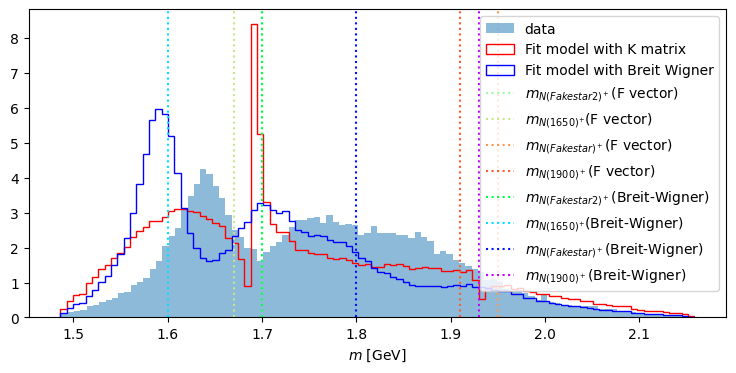

In [39]:

original_parameters = intensity_func_fvector.parameters
intensity_func_fvector.update_parameters(initial_parameters_fvector)
intensity_func_rel_bw.update_parameters(initial_parameters_relbw)
compare_model(
    "m_01", data_real, phsp_real, intensity_func_fvector, intensity_func_rel_bw
)

In [40]:
from tensorwaves.optimizer import Minuit2
from tensorwaves.optimizer.callbacks import CSVSummary

minuit2 = Minuit2(
    callback=CSVSummary("fit_traceback.csv"),
    use_analytic_gradient=False,
)

fit_result_BW = minuit2.optimize(estimator_bw, initial_parameters_relbw)
display("Fit Breit-Wigner:", fit_result_BW)
fit_result_F = minuit2.optimize(estimator_fvector, initial_parameters_fvector)
display("Fit F vector:", fit_result_F)

0it [00:00, ?it/s]

'Fit Breit-Wigner:'

FitResult(
 minimum_valid=True,
 execution_time=4.677215337753296,
 function_calls=460,
 estimator_value=-12198.959244284237,
 parameter_values={
  'm_{N(Fakestar)^+}': 1.8497722024190237,
  'w_{N(Fakestar)^+}': 0.5782959510425077,
  'm_{N(1900)^+}': 1.8979233143190917,
  'w_{N(1900)^+}': 0.5133596540336253,
  'm_{N(Fakestar2)^+}': 1.750670984933865,
  'w_{N(Fakestar2)^+}': 0.5846494642322556,
  'm_{N(1650)^{+}}': 1.6498642685938685,
  'w_{N(1650)^{+}}': 0.620015291718532,
 },
 parameter_errors={
  'm_{N(Fakestar)^+}': 0.0014323314749189518,
  'w_{N(Fakestar)^+}': 0.01925746470118625,
  'm_{N(1900)^+}': 0.0019038409162150155,
  'w_{N(1900)^+}': 0.019434730126103774,
  'm_{N(Fakestar2)^+}': 0.000892931269048051,
  'w_{N(Fakestar2)^+}': 0.013270544273614748,
  'm_{N(1650)^{+}}': 0.00047548447999302897,
  'w_{N(1650)^{+}}': 0.011881206933894169,
 },
)

0it [00:00, ?it/s]

'Fit F vector:'

FitResult(
 minimum_valid=True,
 execution_time=47.1162691116333,
 function_calls=2975,
 estimator_value=-12202.383067702911,
 parameter_values={
  'm_{N(Fakestar)^+}': 2.0582987246008804,
  'm_{N(1900)^+}': 1.8231026455013533,
  'g_{N(1900)^+}': 1.0730078384977024,
  'g_{N(Fakestar)^+}': 1.3133876970845961,
  'm_{N(Fakestar2)^+}': 1.7778710952273362,
  'm_{N(1650)^{+}}': 1.6396907094273547,
  'g_{N(1650)^{+}}': 0.9545451645245374,
  'g_{N(Fakestar2)^+}': 1.0945401433722264,
  '\\beta_{N(Fakestar)^+}': (0.9055666944002341+1.0500508390638388j),
  '\\beta_{N(1900)^+}': (1.273746344719463-1.4101342023704395j),
  '\\beta_{N(Fakestar2)^+}': (1.5062984460066997+0.6457898290798657j),
  '\\beta_{N(1650)^{+}}': (0.9570822021506897-0.8803373376651846j),
 },
 parameter_errors={
  'm_{N(Fakestar)^+}': 0.02416835891604554,
  'm_{N(1900)^+}': 0.006926974109042624,
  'g_{N(1900)^+}': 0.023515895445379586,
  'g_{N(Fakestar)^+}': 0.0916024840987184,
  'm_{N(Fakestar2)^+}': 0.002272635372427852,
  'm_{N

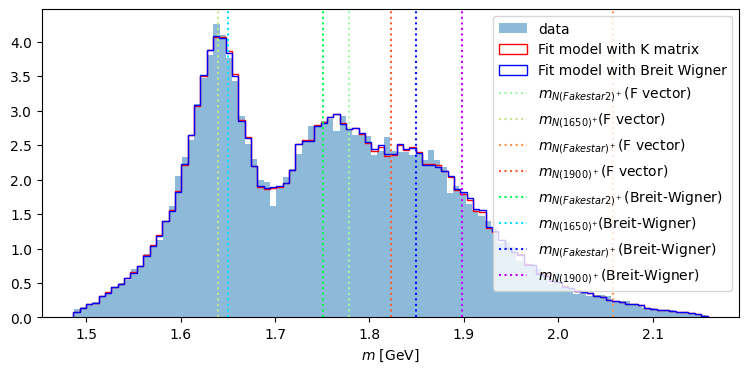

In [41]:
optimized_parameters_BW = fit_result_BW.parameter_values
optimized_parameters_F = fit_result_F.parameter_values
intensity_func_fvector.update_parameters(optimized_parameters_F)
intensity_func_rel_bw.update_parameters(optimized_parameters_BW)
compare_model(
    "m_01", data_real, phsp_real, intensity_func_fvector, intensity_func_rel_bw
)

### Parameters for $F$ vector v.s. sum of Breit-Wigners

In [42]:
for p in optimized_parameters_F:
    print(p)
    print(f"  initial:   {initial_parameters_fvector[p]:.3}")
    print(f"  optimized F vector: {optimized_parameters_F[p]:.3}")
    print(f"  original:  {original_parameters[p]:.3}")
latest_parameters_F = CSVSummary.load_latest_parameters("fit_traceback.csv")
latest_parameters_F

m_{N(Fakestar)^+}
  initial:   1.95
  optimized F vector: 2.06
  original:  1.95
m_{N(1900)^+}
  initial:   1.91
  optimized F vector: 1.82
  original:  1.9
g_{N(1900)^+}
  initial:   1.0
  optimized F vector: 1.07


ValueError: Precision not allowed in integer format specifier

In [ ]:
for p in optimized_parameters_BW:
    print(p)
    print(f"  initial:   {initial_parameters_bw[p]:.3}")
    print(f"  optimized Breit-Wigner: {optimized_parameters_BW[p]:.3}")
    print(f"  original:  {original_parameters[p]:.3}")
latest_parameters_BW = CSVSummary.load_latest_parameters("fit_traceback.csv")
latest_parameters_BW